<a href="https://colab.research.google.com/github/princoo/pytorch-in-ML/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch workflow

In [1]:
what_were_covering = {1:"data (prepare and load)",
                      2:"build model",
                      3:"fitting the model to data (training)",
                      4:"making predictions and evaluating a model (inference)",
                      5:"saving and loading a model",
                      6:"putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all of the building blocks for neural networks
import matplotlib.pyplot as plt

# check Pytorch vervion
torch.__version__

'2.3.1+cu121'

## 1. Data (preparing and loading)

To showcase this, let's create some *known* data using the linear regression formular.

we will use a linera regression formular to make a straight line with known **parameters**

In [ ]:
#  create known parameters
weight = 0.7
bias = 0.3

#  create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]




In [4]:
len(X), len(y)


(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  print(f"Type of predictions: {type(predictions)}")

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

In [ ]:
plot_predictions();

## 2. Build model

Our first PyTorch model!


What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent - https://youtu.be/IHZwWFHWa-w
2. Backpropagation - https://youtu.be/Ilg3gGewQ5U

In [8]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32

    self.bias = nn.Parameter(torch.randn(1, # <- start with a random bias and try to adjust it to the ideal bias
                                         requires_grad=True, # <- can this parameter be updated via gradient descent?
                                         dtype=torch.float)) # <- PyTorch loves the datatype torch.float32

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

See more of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

In [ ]:
#  create a random seed
torch.manual_seed(42)

#  create an instance of the model (this is a subclass of nn.module)
model_0 = LinearRegressionModel()

# list the parameters
list(model_0.parameters())

In [ ]:
# List named parameters
model_0.state_dict()

### making predictions using `torch.inference_mode()`.

we can see the model's pred power , by seeing how well it predicts `y_test` based on `x_test`.

when we pass data to the  model, it runs it through the `forward() method`


In [ ]:
#  make predictions with model

with torch.inference_mode():
  y_predict = model_0(X_test)

# with torch.no_grad(): <- you can also use this one but inference is mostly prefered
#   y_predict = model_0(X_test)

y_predict

In [ ]:
plot_predictions(predictions=y_predict)

### 3. Train model

things we neeed to train the model:
1. Loss function
2. optimizer: takes into account the loss of model and adjust the model's
parameters to improve the loss function.

And specifically for pytorch, we neeed:
* A training loop
* A testing loop

In [13]:
# Set up a loss function
loss_fn = nn.L1Loss()

#  Set up an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), # we want to optimize the parameters in our model
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter

### Building a training loopa(and a testing loop) in PyTorch.

A couple of things we need in a training loop

0. Loop through the data
1. Forward pass (this involves data moving in our model's forward function) to make prediction on data -
also called forwad propagation

2. Calculate the loss(compare forward pass predictions to ground truth labels)

3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**back propagation**)
5. Optimizer step - use the optimizer to adjust parameters to try and improve the loss (**gradient descent**)



In [ ]:
#  an echo is one loop through the data

epochs = 200

# tracking dif values
epoch_count =[]
loss_values =[]
test_loss_values =[]

### TRAINING

# 0. loop through the data

for epoch in range(epochs):
  #  set the model to training mode
  model_0.train() # train mode in pytorch sets all prameters that require gradient to require gradient

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5 . Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  # TESTING
  model_0.eval() # turns off dif settings in the model not needed for evaluation/ testing (dropouts/batch norm layers)
  with torch.inference_mode():
    # 1. forward pass
    test_pred = model_0(X_test)

    # 2. calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  # print whats happening
  if epoch % 10 ==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
  # Print out model state_dict()
  print(model_0.state_dict())

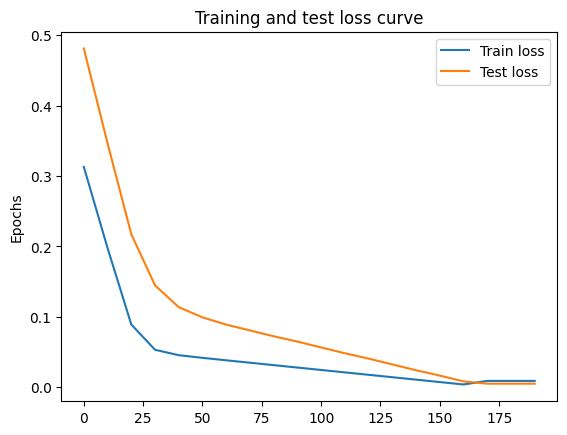

In [15]:
#  plot the loss curves

plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).numpy(), label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.ylabel("Epochs")
plt.legend()

In [16]:
with torch.inference_mode():
  y_pred_new = model_0(X_test)

Type of predictions: <class 'torch.Tensor'>


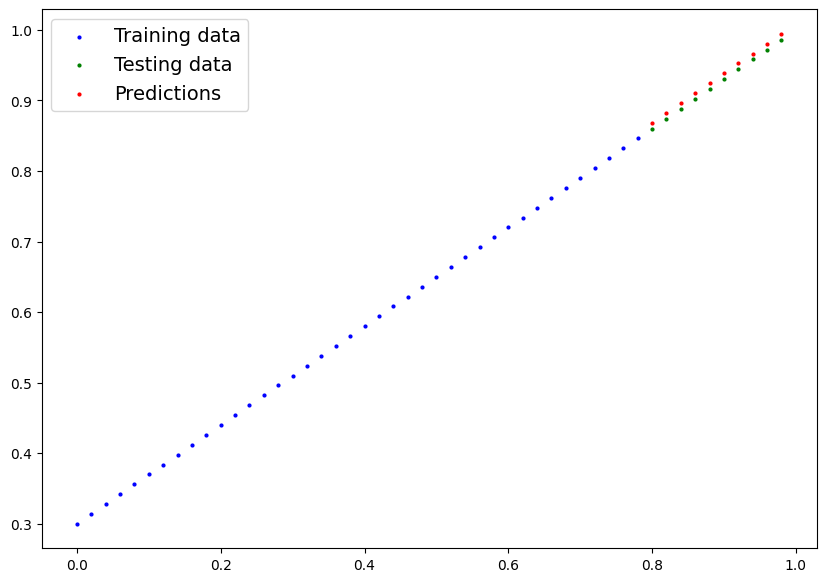

In [17]:
# predictions after some training
plot_predictions(predictions=y_pred_new)

### Saving a model in pytorch

there are 3 main methos for saving and loading model in pytorch

1. `torch.save()` - allows to save a pytorch object in python's pickel format
2. `torch.load()`- allows to load a saves pytorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [18]:
#  Saving our pytorch model
from pathlib import Path

#  1. create a model directory
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. save the model state dicts
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

saving model to: models/01_pytorch_workflow_model_0.pth


In [19]:
# check the model folders
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Aug  8 13:35 01_pytorch_workflow_model_0.pth


### Loading the pytorch model

since we saved the model state_dicts rather thatn the entire model, we'll create an new instance of our model class and load the saved  `state_dicts`

In [20]:
loaded_model_0 = LinearRegressionModel()

#  load the saved statedicts of model_0 (this will update the instance with the updated parameter)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
#  just for testing lets make predictions using our loaded model
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_pred = loaded_model_0(X_test)

loaded_model_pred

In [ ]:
model_0.eval()

with torch.inference_mode():
  y_pred = model_0(X_test)

#  now lets compare the prediction for both models
y_pred == loaded_model_pred

## 6. putting it all together

lets go back through the steps above and see it all in one place

In [24]:
# import neccessary packages
import torch
from torch import nn
import matplotlib.pyplot as plt

# we check pytorch version
torch.__version__

'2.3.1+cu121'

In [25]:
#  create device-agnostic code (for when we have GPU if available)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 6.1 *Data*

In [ ]:
#  create some data using linear regression formular
#  y = Bx + A or weight + bias
weight = 0.7
bias = 0.3
#  create range values

start = 0
end = 1
step = 0.02
#  create X and Y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1) # without unsqueeze erros will pop out
y = weight * X + bias

X[:10], y[:10]

In [27]:
#  Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Building a pytorch Linear model

In [29]:
#   create a linera model by subclassing nn.Module

class LinearRegressionV2(nn.Module):
  def __init__(self):
    super().__init__()
    #  Use nn.Linear() for creating model params / also called : linear transorm,probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.linear_layer(x)

#  set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionV2()
model_1, model_1.state_dict()

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [30]:
#  check the model current device
next(model_1.parameters()).device
#  or use this below
# list(model_1.parameters())[0].device

device(type='cpu')

In [ ]:
#  set the model to use the target device
model_1.to(device)

### 6.3 training

for training we need :
1. loss function
2. optimizer
3. training loop
4. testing loop



In [32]:
#  seeting up a loss function
loss_fn = nn.L1Loss() # same as MAE

#  set up  optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr=0.01,)

In [ ]:
#  Lets write a training loop
torch.manual_seed(42)

epochs = 200

#  put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  #  1. forward pass
  y_pred = model_1(X_train)
  # 2. calculate the loss
  loss = loss_fn(y_pred,y_train)
  # 3. optimizer zero grad
  optimizer.zero_grad()
  # 4. perform backpropagation
  loss.backward()
  # 5. optimizer  step
  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)

  test_loss = loss_fn(test_pred, y_test)

  #  print out whats happening

  if epoch % 10 == 0:
    print(f"Epoch:{epoch} | Loss:{loss} | test loss:{test_loss}")

In [34]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluation **predictions**

In [ ]:
#  turn model into evaluation mode

model_1.eval()

#  make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

In [65]:
print(type(y_preds)) # check the type of tensor
y_pred_cpu = y_preds.cpu() # send the tensor to the cpu
print(y_pred_cpu.device)
y_pred_numpy = y_pred_cpu.numpy() # change the tensor type to numpy in order to be plotted cz matplot lib supppprts cpu based tensors which are also numpy arrays
print(type(y_pred_numpy))


<class 'torch.Tensor'>
cpu
<class 'numpy.ndarray'>


Type of predictions: <class 'numpy.ndarray'>


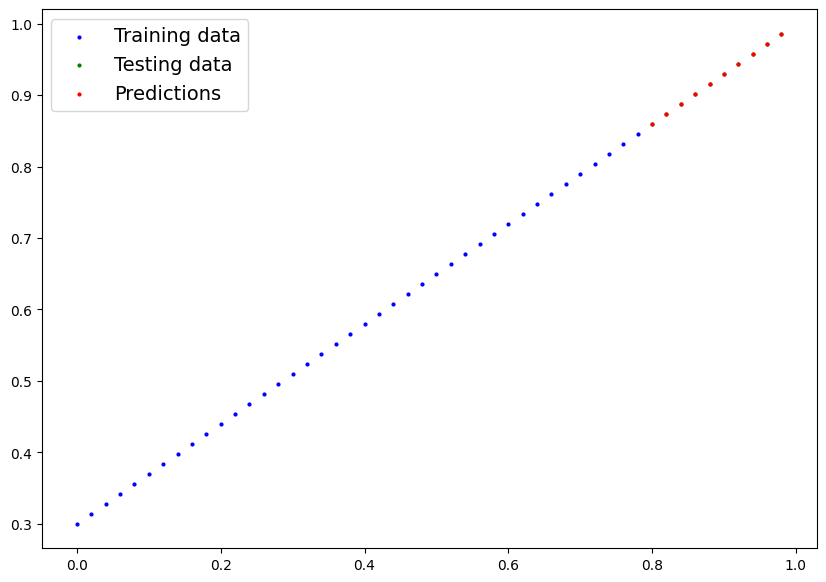

In [59]:
#  check the model predictions visually
plot_predictions(predictions=y_pred_numpy)

### 6.5 Saving and Loading the model

In [41]:
from pathlib import Path

# 1. create a model path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. create a model save path
MODEL_NAME = "01_ptorch_workflow_model_1.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model state dict
print (f"daving model to:{MODEL_SAVE_PATH}")
torch.save(obj= model_1.state_dict(),
           f= MODEL_SAVE_PATH)

daving model to:models/01_ptorch_workflow_model_1.pth


In [61]:
#  Load the model

#  we create a new instance of linear regression model v2
loaded_model_1 = LinearRegressionV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

#  put the loaded model to the device

loaded_model_1.to(device)

LinearRegressionV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [54]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [56]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
#  evaluate the loaded model

loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

# loaded_model_1_preds.device , y_preds.device
y_preds == loaded_model_1_preds